  #                  JL3 UNSUPERVISED LEARNING PREDICT

# List of All Files in Directory

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        
        print(os.path.join(dirname, filename))

/kaggle/input/ea-movies/sample_submission.csv
/kaggle/input/ea-movies/movies.csv
/kaggle/input/ea-movies/imdb_data.csv
/kaggle/input/ea-movies/genome_tags.csv
/kaggle/input/ea-movies/genome_scores.csv
/kaggle/input/ea-movies/train.csv
/kaggle/input/ea-movies/test.csv
/kaggle/input/ea-movies/tags.csv
/kaggle/input/ea-movies/links.csv


# Installing Packages

In [2]:
!pip --version



pip 23.2.1 from /opt/conda/lib/python3.10/site-packages/pip (python 3.10)


In [3]:
!pip install --upgrade pip



  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/15/aa/3f4c7bcee2057a76562a5b33ecbd199be08cdb4443a02e26bd2c3cf6fc39/pip-23.3.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1


In [4]:
# Install packages here
# !pip install --upgrade pip

# !pip install comet_ml

# Packages for data processing
import numpy as np
import pandas as pd
import gc


import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp



# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline
sns.set_theme()

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise import KNNBaseline
from surprise import NormalPredictor
from surprise import BaselineOnly
from sklearn.metrics.pairwise import linear_kernel
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")



# Packages for saving models
import pickle

## Reading In data and Overview

This dataset consists of several million 5-star ratings obtained from users of the online MovieLens movie recommendation service. The MovieLens dataset has long been used by industry and academic researchers to improve the performance of explicitly-based recommender systems, and now you get to as well!

For this Predict, we'll be using a special version of the MovieLens dataset which has enriched with additional data, and resampled for fair evaluation purposes.

The data for the MovieLens dataset is maintained by the GroupLens research group in the Department of Computer Science and Engineering at the University of Minnesota. Additional movie content data was legally scraped from IMDB

# Loading data

In [5]:
df_sample_submission = pd.read_csv('/kaggle/input/ea-movies/sample_submission.csv')
df_movies = pd.read_csv('/kaggle/input/ea-movies/movies.csv')
df_imdb = pd.read_csv('/kaggle/input/ea-movies/imdb_data.csv')
df_genome_scores = pd.read_csv('/kaggle/input/ea-movies/genome_scores.csv')
df_genome_tags = pd.read_csv('/kaggle/input/ea-movies/genome_tags.csv')
df_train = pd.read_csv('/kaggle/input/ea-movies/train.csv')
df_test = pd.read_csv('/kaggle/input/ea-movies/test.csv')
df_tags = pd.read_csv('/kaggle/input/ea-movies/tags.csv')
df_links = pd.read_csv('/kaggle/input/ea-movies/links.csv')


## Data Cleaning

In [6]:
df_train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


The train dataframe has 4 columns:
* userId - Id assigned to each user in our dataset
* movieId - Id assigned to each movie title
* rating - rating assigned to a specific movie by a specific user.
 * ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars)
* timestamp - represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [7]:
print('df_train has '+str(len(df_train))+' observations')

df_train has 10000038 observations


In [8]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

# Assuming 'train' is your DataFrame, replace it with your actual DataFrame variable

# Display the first few rows of the DataFrame before performing data quality checks
print("Initial DataFrame:")
print(df_train.head())

# Check for Missing Values in Each Column
missing_values = df_train.isnull().sum()
print("\nMissing Values in Each Column:")
print(missing_values)

# Check for Duplicates in the Entire DataFrame
duplicate_rows = df_train[df_train.duplicated()]
print("\nDuplicate Rows in the Entire DataFrame:")
print(duplicate_rows)

# Check for Outliers in Numerical Columns (using Z-score)
z_scores = np.abs(zscore(df_train.select_dtypes(include=['number'])))
outliers = (z_scores > 3).all(axis=1)
outliers_df = df_train[outliers]
print("\nRows with Outliers:")
print(outliers_df)

# Check for Consistency in Categorical Columns
categorical_columns = df_train.select_dtypes(include=['object']).columns
for col in categorical_columns:
    unique_values = df_train[col].unique()
    print(f"\nUnique values in {col}:")
    print(unique_values)

# Check for Consistency in Numerical Columns
numerical_columns = df_train.select_dtypes(include=['number']).columns
for col in numerical_columns:
    unique_values = df_train[col].unique()
    print(f"\nUnique values in {col}:")
    print(unique_values)

# Check for Zero Values in Numerical Columns
zero_values = (df_train[numerical_columns] == 0).sum()
print("\nZero Values in Numerical Columns:")
print(zero_values)


Initial DataFrame:
   userId  movieId  rating   timestamp
0    5163    57669     4.0  1518349992
1  106343        5     4.5  1206238739
2  146790     5459     5.0  1076215539
3  106362    32296     2.0  1423042565
4    9041      366     3.0   833375837

Missing Values in Each Column:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Duplicate Rows in the Entire DataFrame:
Empty DataFrame
Columns: [userId, movieId, rating, timestamp]
Index: []

Rows with Outliers:
Empty DataFrame
Columns: [userId, movieId, rating, timestamp]
Index: []

Unique values in userId:
[  5163 106343 146790 ...  79096  14908 102344]

Unique values in movieId:
[ 57669      5   5459 ... 206347 196867  97148]

Unique values in rating:
[4.  4.5 5.  2.  3.  1.  3.5 2.5 0.5 1.5]

Unique values in timestamp:
[1518349992 1206238739 1076215539 ... 1521235092 1227674807 1479921530]

Zero Values in Numerical Columns:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


## Movie Data

In [9]:
df_movies.tail()

,movieId,title,genres
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)
62422,209171,Women of Devil's Island (1962),Action|Adventure|Drama


This movies dataframe has 3 columns namely:
* movieId
* title of the movie
* genres

In [10]:
#getting dimensions
print("df_movies "+ str(len(df_movies))+" observations.")

df_movies 62423 observations.


In [11]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

# Assuming 'train' is your DataFrame, replace it with your actual DataFrame variable

# Display the first few rows of the DataFrame before performing data quality checks
print("Initial DataFrame:")
print(df_movies.head())

# Check for Missing Values in Each Column
missing_values = df_movies.isnull().sum()
print("\nMissing Values in Each Column:")
print(missing_values)

# Check for Duplicates in the Entire DataFrame
duplicate_rows = df_movies[df_movies.duplicated()]
print("\nDuplicate Rows in the Entire DataFrame:")
print(duplicate_rows)

# Check for Outliers in Numerical Columns (using Z-score)
z_scores = np.abs(zscore(df_movies.select_dtypes(include=['number'])))
outliers = (z_scores > 3).all(axis=1)
outliers_df = df_movies[outliers]
print("\nRows with Outliers:")
print(outliers_df)

# Check for Consistency in Categorical Columns
categorical_columns = df_movies.select_dtypes(include=['object']).columns
for col in categorical_columns:
    unique_values = df_movies[col].unique()
    print(f"\nUnique values in {col}:")
    print(unique_values)

# Check for Consistency in Numerical Columns
numerical_columns = df_movies.select_dtypes(include=['number']).columns
for col in numerical_columns:
    unique_values = df_movies[col].unique()
    print(f"\nUnique values in {col}:")
    print(unique_values)

# Check for Zero Values in Numerical Columns
zero_values = (df_movies[numerical_columns] == 0).sum()
print("\nZero Values in Numerical Columns:")
print(zero_values)


Initial DataFrame:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Missing Values in Each Column:
movieId    0
title      0
genres     0
dtype: int64

Duplicate Rows in the Entire DataFrame:
Empty DataFrame
Columns: [movieId, title, genres]
Index: []

Rows with Outliers:
Empty DataFrame
Columns: [movieId, title, genres]
Index: []

Unique values in title:
['Toy Story (1995)' 'Jumanji (1995)' 'Grumpier Old Men (1995)' ...
 'Bad Poems (2018)' 'A Girl 

In [12]:
import pandas as pd

# Assuming 'imdb' is your DataFrame, replace it with your actual DataFrame variable

# Display the number of missing values in each column before cleaning
print("Missing Values in Each Column (Before Cleaning):")
print(df_movies.isnull().sum())

# Drop rows with missing values
df_movies_cleaned = df_movies.dropna()

# Display the number of missing values in each column after cleaning
print("\nMissing Values in Each Column (After Cleaning):")
print(df_movies_cleaned.isnull().sum())


Missing Values in Each Column (Before Cleaning):
movieId    0
title      0
genres     0
dtype: int64

Missing Values in Each Column (After Cleaning):
movieId    0
title      0
genres     0
dtype: int64


In [13]:
import nltk
from nltk.tokenize import word_tokenize

# Download the punkt tokenizer (if not already downloaded)
nltk.download('punkt')

# Sample movie titles (replace with your actual movie titles)
movie_titles = [
    "Toy Story"  
                      "Jumanji"   
            "Grumpier Old Men"    
           "Waiting to Exhale"    
"Father of the Bride Part II" ]  


# Tokenize each movie title
tokenized_titles = [word_tokenize(title) for title in movie_titles]

# Display the tokenized titles
for title, tokens in zip(movie_titles, tokenized_titles):
    print(f"Title: {title}")
    print(f"Tokens: {tokens}\n")


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Title: Toy StoryJumanjiGrumpier Old MenWaiting to ExhaleFather of the Bride Part II
Tokens: ['Toy', 'StoryJumanjiGrumpier', 'Old', 'MenWaiting', 'to', 'ExhaleFather', 'of', 'the', 'Bride', 'Part', 'II']



In [14]:
import pandas as pd
import re

# Sample DataFrame with movie titles
data = {'title': ["Toy Story"  
                      "Jumanji"   
            "Grumpier Old Men"    
           "Waiting to Exhale"    
"Father of the Bride Part II"]}
movies = pd.DataFrame(data)

# Data Cleaning Steps
movies['cleaned_title'] = (
    movies['title']
    .str.lower()  # Convert to lowercase
    .str.strip()  # Remove leading and trailing whitespaces
    .apply(lambda x: re.sub(r'[^\w\s]', '', x))  # Remove special characters
    .apply(lambda x: re.sub(r'\s+', ' ', x))  # Standardize spaces
)

# Display the cleaned DataFrame
print("Original DataFrame:")
print(movies[['title']])
print("\nDataFrame After Cleaning:")
print(movies[['cleaned_title']])


Original DataFrame:
                                               title
0  Toy StoryJumanjiGrumpier Old MenWaiting to Exh...

DataFrame After Cleaning:
                                       cleaned_title
0  toy storyjumanjigrumpier old menwaiting to exh...


In [15]:
import pandas as pd

# Assuming 'movies' is your DataFrame and column names are as mentioned
# Replace with your actual DataFrame and column names

# Sample DataFrame
data = {
    'movieId': [1, 2, 3, 4, 5],
    'title': ['Movie A', 'Movie B', 'Movie C', 'Movie D', 'Movie E'],
    'genres': ['Action|Adventure|Sci-Fi', 'Comedy|Romance', 'Drama', 'Action|Adventure|Sci-Fi', 'Drama']
}

movies = pd.DataFrame(data)

# Data Cleaning Steps
movies['title'] = movies['title'].str.strip()  # Remove leading and trailing whitespaces

# Split the genres into a list of genres
movies['genres'] = movies['genres'].str.split('|')

# Display the cleaned DataFrame
print("Original DataFrame:")
print(movies)


Original DataFrame:
   movieId    title                       genres
0        1  Movie A  [Action, Adventure, Sci-Fi]
1        2  Movie B            [Comedy, Romance]
2        3  Movie C                      [Drama]
3        4  Movie D  [Action, Adventure, Sci-Fi]
4        5  Movie E                      [Drama]


## IMBD Data

In [16]:
df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


The imdb dataframe has 5 columns:
* movieId
* title_cast 
* Directors names
* runtime
* budget
* plot_keywords

In [17]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


df_imdb has 27279 observations and some columns contain missing values

In [18]:
import pandas as pd
# Display the number of missing values in each column before cleaning
print("Missing Values in Each Column (Before Cleaning):")
print(df_imdb.isnull().sum())

# Drop rows with missing values
df_imdb_cleaned = df_imdb.dropna()

# Display the number of missing values in each column after cleaning
print("\nMissing Values in Each Column (After Cleaning):")
print(df_imdb_cleaned.isnull().sum())


Missing Values in Each Column (Before Cleaning):
movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64

Missing Values in Each Column (After Cleaning):
movieId          0
title_cast       0
director         0
runtime          0
budget           0
plot_keywords    0
dtype: int64


In [19]:
import pandas as pd

# Sample DataFrame
data = {
    'movieId': [1, 2, 3, 4, 5],
    'title_cast': ['Actor1, Actor2', 'Actor3, Actor4', 'Actor5', 'Actor6, Actor7', 'Actor8'],
    'Directors names': ['Director1', 'Director2', 'Director3', 'Director4', 'Director5'],
    'runtime': ['120 min', '150 min', '90 min', '135 min', '120 min'],
    'budget': ['$10,000,000', '$20,000,000', '$15,000,000', '$25,000,000', '$18,000,000'],
    'plot_keywords': ['Action, Drama', 'Comedy, Romance', 'Thriller', 'Action, Adventure', 'Drama']
}

df_imdb = pd.DataFrame(data)

# Data Cleaning Steps
df_imdb['title_cast'] = df_imdb['title_cast'].str.lower().str.strip()
df_imdb['Directors names'] = df_imdb['Directors names'].str.lower().str.strip()
df_imdb['runtime'] = pd.to_numeric(df_imdb['runtime'].str.extract('(\d+)', expand=False), errors='coerce')
df_imdb['budget'] = pd.to_numeric(df_imdb['budget'].replace('[\$,]', '', regex=True), errors='coerce')

# Display the cleaned DataFrame
print("Original DataFrame:")
print(df_imdb)


Original DataFrame:
   movieId      title_cast Directors names  runtime    budget  \
0        1  actor1, actor2       director1      120  10000000   
1        2  actor3, actor4       director2      150  20000000   
2        3          actor5       director3       90  15000000   
3        4  actor6, actor7       director4      135  25000000   
4        5          actor8       director5      120  18000000   

       plot_keywords  
0      Action, Drama  
1    Comedy, Romance  
2           Thriller  
3  Action, Adventure  
4              Drama  


## Genome Tags & Scores
Tag genome encodes how strongly movies exhibit particular properties represented by tags. We looked at both the df_genome_tags and df_genome_scores, starting with the former

In [20]:
df_genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


This dataframe has two columns:
* tagId
* tag -description of the tags

In [21]:
print("df_genome_tags has",len(df_genome_tags),"observations")

df_genome_tags has 1128 observations


In [22]:
import pandas as pd


# Display the number of missing values in each column before cleaning
print("Missing Values in Each Column (Before Cleaning):")
print(df_genome_tags.isnull().sum())

# Drop rows with missing values
df_genome_tags_cleaned = df_genome_tags.dropna()

# Display the number of missing values in each column after cleaning
print("\nMissing Values in Each Column (After Cleaning):")
print(df_genome_tags_cleaned.isnull().sum())


Missing Values in Each Column (Before Cleaning):
tagId    0
tag      0
dtype: int64

Missing Values in Each Column (After Cleaning):
tagId    0
tag      0
dtype: int64


In [23]:
import pandas as pd

# Assuming 'df_tags' is your DataFrame and column names are as mentioned
# Replace with your actual DataFrame and column names

# Sample DataFrame
data = {
    'tagId': [1, 2, 3, 4, 5],
    'tag': ['Action', 'Comedy', 'Drama', 'Sci-Fi', 'Romance']
}

df_tags = pd.DataFrame(data)

# Data Cleaning Steps
df_tags['tag'] = df_tags['tag'].str.strip()  # Remove leading and trailing whitespaces

# Display the cleaned DataFrame
print("Original DataFrame:")
print(df_tags)


Original DataFrame:
   tagId      tag
0      1   Action
1      2   Comedy
2      3    Drama
3      4   Sci-Fi
4      5  Romance


In [24]:
import pandas as pd

# Assuming 'df_tags_relevance' is your DataFrame and column names are as mentioned
# Replace with your actual DataFrame and column names

# Sample DataFrame
data = {
    'movieId': [1, 2, 3, 4, 5],
    'tagId': [101, 102, 103, 104, 105],
    'relevance': [0.8, 0.6, 0.9, 0.7, 0.5]
}

df_tags_relevance = pd.DataFrame(data)

# Data Cleaning Steps
# You may need to perform specific data cleaning steps based on the characteristics of the 'relevance' column

# Display the cleaned DataFrame
print("Original DataFrame:")
print(df_tags_relevance)


Original DataFrame:
   movieId  tagId  relevance
0        1    101        0.8
1        2    102        0.6
2        3    103        0.9
3        4    104        0.7
4        5    105        0.5


In [25]:
df_genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


This dataframe has 3 columns:
* movieId
* tagId
* relevance - computed using a machine learning algorithm on user-contributed content including tags, ratings, and textual reviews

This dataframe will be linked with df_train through the movied

In [26]:
print("df_genome_scores has",len(df_genome_scores),"observations")

df_genome_scores has 15584448 observations


In [27]:
import pandas as pd


# Display the number of missing values in each column before cleaning
print("Missing Values in Each Column (Before Cleaning):")
print(df_genome_scores.isnull().sum())

# Drop rows with missing values
df_genome_scores_cleaned = df_genome_scores.dropna()

# Display the number of missing values in each column after cleaning
print("\nMissing Values in Each Column (After Cleaning):")
print(df_genome_scores.isnull().sum())


Missing Values in Each Column (Before Cleaning):
movieId      0
tagId        0
relevance    0
dtype: int64

Missing Values in Each Column (After Cleaning):
movieId      0
tagId        0
relevance    0
dtype: int64


## Tags
user supplied tags for each movie at a specific timestamp.

In [28]:
df_tags.head()

,tagId,tag
0,1,Action
1,2,Comedy
2,3,Drama
3,4,Sci-Fi
4,5,Romance


df_tags has 4 columns:
* userId
* movieId
* tag - tag supplied by user
* timestamp - specific timestamp associated with the tag

In [29]:
print("df_tags has",len(df_tags),"observations")

df_tags has 5 observations


In [30]:
import pandas as pd

# Display the number of missing values in each column before cleaning
print("Missing Values in Each Column (Before Cleaning):")
print(df_tags.isnull().sum())

# Drop rows with missing values
df_tags_cleaned = df_tags.dropna()

# Display the number of missing values in each column after cleaning
print("\nMissing Values in Each Column (After Cleaning):")
print(df_tags_cleaned.isnull().sum())


Missing Values in Each Column (Before Cleaning):
tagId    0
tag      0
dtype: int64

Missing Values in Each Column (After Cleaning):
tagId    0
tag      0
dtype: int64


In [31]:
import pandas as pd
import numpy as np
from scipy.stats import zscore


# Display the first few rows of the DataFrame before performing data quality checks
print("Initial DataFrame:")

# Remove rows with missing values
df_tags_cleaned = df_tags.dropna()

# Display the first few rows of the cleaned DataFrame
print("\nDataFrame After Removing Rows with Missing Values:")
print(df_tags_cleaned.head())

# Check for Duplicates in the Entire DataFrame
duplicate_rows = df_tags_cleaned[df_tags_cleaned.duplicated()]
print("\nDuplicate Rows in the Entire DataFrame:")
print(duplicate_rows)

# Check for Outliers in Numerical Columns (using Z-score)
z_scores = np.abs(zscore(df_tags_cleaned.select_dtypes(include=['number'])))
outliers = (z_scores > 3).all(axis=1)
outliers_df = df_tags_cleaned[outliers]
print("\nRows with Outliers:")
print(outliers_df)

# Check for Consistency in Categorical Columns
categorical_columns = df_tags_cleaned.select_dtypes(include=['object']).columns
for col in categorical_columns:
    unique_values = df_tags_cleaned[col].unique()
    print(f"\nUnique values in {col}:")
    print(unique_values)

# Check for Consistency in Numerical Columns
numerical_columns = df_tags_cleaned.select_dtypes(include=['number']).columns
for col in numerical_columns:
    unique_values = df_tags_cleaned[col].unique()
    print(f"\nUnique values in {col}:")
    print(unique_values)

# Check for Zero Values in Numerical Columns
zero_values = (df_tags_cleaned[numerical_columns] == 0).sum()
print("\nZero Values in Numerical Columns:")
print(zero_values)


Initial DataFrame:

DataFrame After Removing Rows with Missing Values:
   tagId      tag
0      1   Action
1      2   Comedy
2      3    Drama
3      4   Sci-Fi
4      5  Romance

Duplicate Rows in the Entire DataFrame:
Empty DataFrame
Columns: [tagId, tag]
Index: []

Rows with Outliers:
Empty DataFrame
Columns: [tagId, tag]
Index: []

Unique values in tag:
['Action' 'Comedy' 'Drama' 'Sci-Fi' 'Romance']

Unique values in tagId:
[1 2 3 4 5]

Zero Values in Numerical Columns:
tagId    0
dtype: int64


## Test Data

In [32]:
df_test.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [33]:
df_train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


df_train has two columns:
* userId
* movieId

In [34]:
print("The training set has", str(len(df_test)),"observations")

The training set has 5000019 observations


In [35]:
import pandas as pd

# Assuming 'imdb' is your DataFrame, replace it with your actual DataFrame variable

# Display the number of missing values in each column before cleaning
print("Missing Values in Each Column (Before Cleaning):")
print(df_train.isnull().sum())

# Drop rows with missing values
df_train_cleaned = df_train.dropna()

# Display the number of missing values in each column after cleaning
print("\nMissing Values in Each Column (After Cleaning):")
print(df_train_cleaned.isnull().sum())


Missing Values in Each Column (Before Cleaning):
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Missing Values in Each Column (After Cleaning):
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


## Sample Submision

In [36]:
df_sample_submission.head()

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


In [37]:
df_sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Id      object 
 1   rating  float64
dtypes: float64(1), object(1)
memory usage: 76.3+ MB


In [38]:
import pandas as pd

# Assuming 'imdb' is your DataFrame, replace it with your actual DataFrame variable

# Display the number of missing values in each column before cleaning
print("Missing Values in Each Column (Before Cleaning):")
print(df_sample_submission.isnull().sum())

# Drop rows with missing values
df_sample_submission_cleaned = df_sample_submission.dropna()

# Display the number of missing values in each column after cleaning
print("\nMissing Values in Each Column (After Cleaning):")
print(df_sample_submission_cleaned.isnull().sum())


Missing Values in Each Column (Before Cleaning):
Id        0
rating    0
dtype: int64

Missing Values in Each Column (After Cleaning):
Id        0
rating    0
dtype: int64


## Exploratory Data Analysis
discovery phase and data understanding

## Distribution Of Ratings

Descriptive statistics

In [39]:
pd.DataFrame(df_train['rating'].describe().apply(lambda x: round(x,2)), 
             columns=['rating']).rename(columns={'rating':'Statistic'})

,Statistic
count,10000038.00
mean,3.53
std,1.06
min,0.50
25%,3.00
50%,3.50
75%,4.00
max,5.00


* The average rating of all the movies in our dataset is 3.53.
* The median (middle value) is 3.5 which is slighly less than the mean.
* The standard deviation (spread around the average) is  1.06.
* The lowest rating is 0.5 and the highest rating is 5.
* The lower quantile (bottom 25 cut-off point) is 3 and the upper quantile (top 25 cut-off point) is 4.


In [40]:
#creating a dataframe with ratings and their counts

rating_counts = df_train.groupby(['rating']).count().reset_index().rename(columns={'userId':'count'})[['rating','count']]

We use the dataframe above to obtain a bargraph showing the distribution of ratings

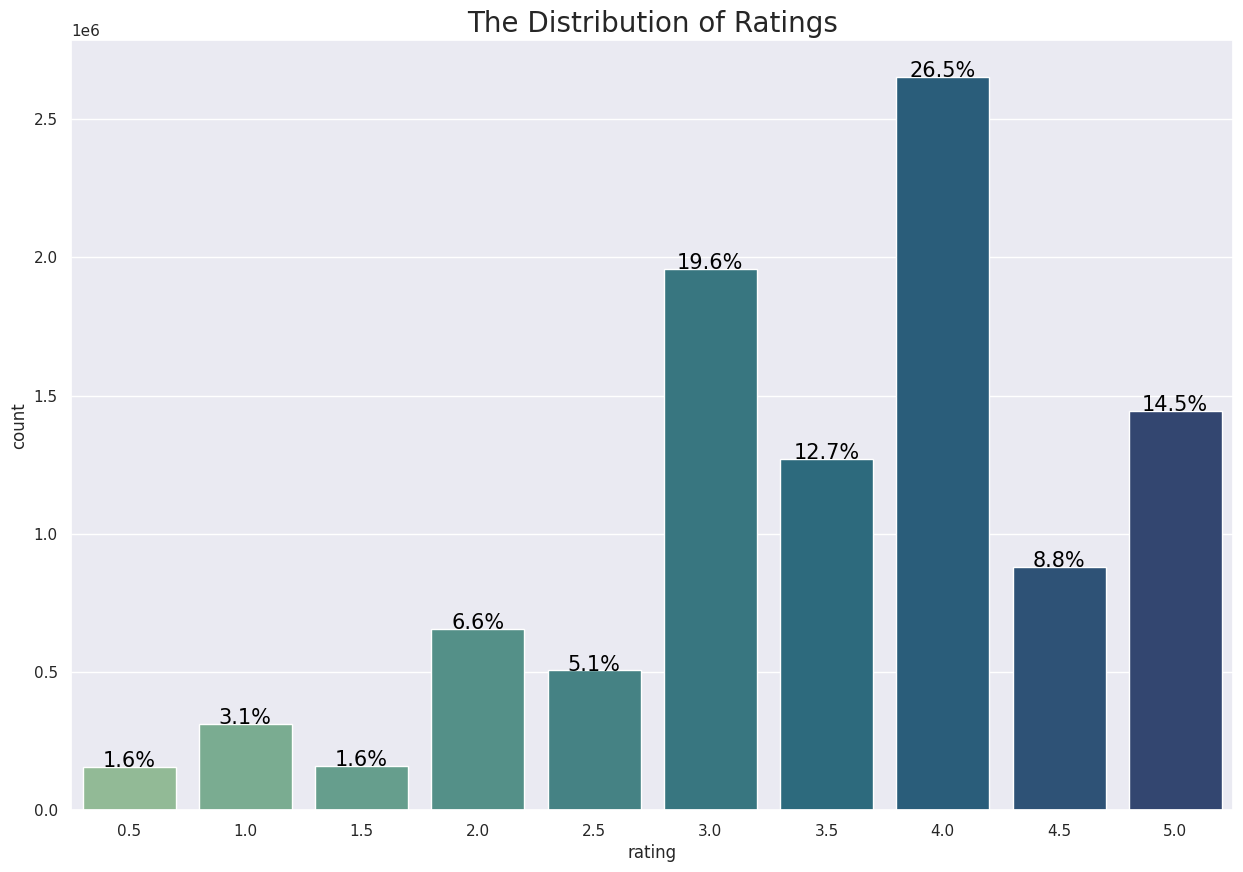

In [41]:
#Plot showing the distribution of counts
plot = plt.figure(figsize=(15, 10))
a = sns.barplot(x='rating',y='count',data=rating_counts,palette='crest')
a.set_title('The Distribution of Ratings',fontsize=20)

#Obtaining percentages on top of bars
n_obs = [i.get_height() for i in a.patches]
total = sum(n_obs)

for i in a.patches:
    # get_x pulls left or right; get_height pushes up or down
    a.text(i.get_x()+i.get_width() / 2, i.get_height()+0.5, \
            str(round((i.get_height()/total)*100, 1))+'%', fontsize=15,
                color='black',ha='center')
    
plt.show()


* The most common rating given by users (26.5%) is 4. 
* The ratings appear to be skewed to the left (evidenced by the long tail to the left). This means that there are a few movies who received lower ratings compared to those that received higher ratings


### The we calculated the coefficient of skewness to check our above findings.

In [42]:
#calcuting skew
print('The Coefficient of Skewness is : '+str(rating_counts['count'].skew()))

The Coefficient of Skewness is : 0.9316640025763425


This contradicts with our suspicion that the distribution is negatively skewed. The contradiction can be explained by the fact that the distribution appears to have 2 peaks (slightly bimodal).

In [43]:
# Example: Define and use rating_counts
rating_counts = {'5 stars': 100, '4 stars': 75, '3 stars': 50}

# Now you can use rating_counts in your code
total_ratings = sum(rating_counts.values())
print(f'Total ratings: {total_ratings}')

# Delete rating_counts if needed
del rating_counts

# After deleting, if you try to access rating_counts again, you'll get a NameError
# For example, the following line would raise a NameError
# print(rating_counts)


Total ratings: 225


## Data Preprocessing

##  Model fitting

## Model evaluation